In [1]:
# Import necessary libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from datetime import datetime, timedelta
import random

In [54]:
# url wuth API key
api_url='https://newsapi.org/v2/everything?q=tesla&from=2025-11-05&sortBy=publishedAt&apiKey=a71107490d714e7f966e718270d5eee2'

<h1>Data Acquisition</h1>

In [55]:
response = requests.get(api_url)
response.raise_for_status() # Raises HTTPError for bad responses (4xx or 5xx)
data = response.json()
data

{'status': 'ok',
 'totalResults': 264,
 'articles': [{'source': {'id': None, 'name': 'Macitynet.it'},
   'author': 'Francesca Testa',
   'title': 'Elon Musk fa tremare tutti, l’annuncio inaspettato: ecco come saranno davvero gli smartphone del futuro',
   'description': 'Elon Musk allerta l’attenzione dei media: l’annuncio sugli smartphone del futuro sorprende tutti. Ecco come saranno.\xa0 Innovativo, rivoluzionario, e per molti inarrestabile, Elon Musk guarda al futuro tecnologico in modo decisamente originale e auspica cambiam…',
   'url': 'https://www.macitynet.it/elon-musk-fa-tremare-tutti-lannuncio-inaspettato-ecco-come-saranno-davvero-gli-smartphone-del-futuro/',
   'urlToImage': 'https://www.macitynet.it/wp-content/uploads/2025/11/Elon-Musk-4112025-Macitynet-it.jpg',
   'publishedAt': '2025-11-05T13:00:14Z',
   'content': 'Elon Musk allerta l’attenzione dei media: l’annuncio sugli smartphone del futuro sorprende tutti. Ecco come saranno.\xa0\r\nInnovativo, rivoluzionario, e per 

In [56]:
all_articles = []
for article in data:
    articles = data['articles']
    all_articles.extend(articles)
    
# Convert all_articles to DataFrame
df_raw = pd.DataFrame(all_articles)
print("\n--- Raw Data Snapshot ---")
print(df_raw.head())
print(f"Raw DataFrame shape: {df_raw.shape}")


--- Raw Data Snapshot ---
                                              source  \
0               {'id': None, 'name': 'Macitynet.it'}   
1                 {'id': None, 'name': 'Www.abc.es'}   
2                   {'id': None, 'name': 'Feber.se'}   
3  {'id': 'business-insider', 'name': 'Business I...   
4                   {'id': None, 'name': 'Finextra'}   

                                  author  \
0                        Francesca Testa   
1                                  (abc)   
2                            Bobby Green   
3  Lloyd Lee,Shubhangi Goel,Nora Redmond   
4                         Editorial Team   

                                               title  \
0  Elon Musk fa tremare tutti, l’annuncio inaspet...   
1  El fondo soberano noruego, en contra del chequ...   
2  Alfa och Maserati ska ta fram specialversioner...   
3  Business leaders from Bill Ackman to Andrew Ya...   
4  The $100 Billion Question: Why the Future of B...   

                                  

In [58]:
# Convert 'publishedAt' to datetime objects
df = df_raw.copy() # Work on a copy to preserve raw data if needed
df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')

# Drop rows where 'publishedAt' conversion failed (NaT)
df.dropna(subset=['publishedAt'], inplace=True)

# Extract hour of publication
df['publication_hour'] = df['publishedAt'].dt.hour

ab_group
B    183
A    108
Name: count, dtype: int64

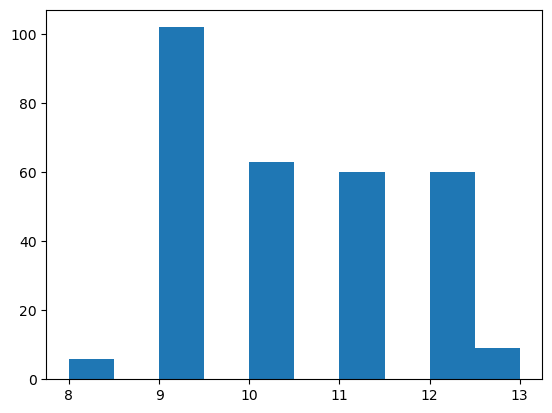

In [59]:
#checking the distribution of the time the articles were published
plt.hist(df['publication_hour']);

In [60]:
# Assign to A/B Groups based on Timing- Early hours of the morning were grouped to A, while late hours were grouped to group B
df['ab_group'] = df['publication_hour'].apply(lambda hour: 'A' if 6 <= hour <=9 else ('B' if 10 <= hour <=12 else 'Excl'))

# Exclude articles not falling into our test windows
df_ab_test = df[df['ab_group'].isin(['A', 'B'])].copy()

df_ab_test['ab_group'].value_counts()

ab_group
B    183
A    108
Name: count, dtype: int64

In [61]:
df_ab_test

,source,author,title,description,url,urlToImage,publishedAt,content,publication_hour,ab_group
3,"{'id': 'business-insider', 'name': 'Business I...","Lloyd Lee,Shubhangi Goel,Nora Redmond",Business leaders from Bill Ackman to Andrew Ya...,"Business leaders, including Bill Ackman and An...",https://www.businessinsider.com/business-leade...,https://i.insider.com/690b0347c007ca8c273846f4...,2025-11-05 12:58:25+00:00,"Business leaders, including Bill Ackman, congr...",12,B
4,"{'id': None, 'name': 'Finextra'}",Editorial Team,The $100 Billion Question: Why the Future of B...,When Tesla first announced its $1.5 billion Bi...,https://www.finextra.com/blogposting/29757/the...,https://www.finextra.com/finextra-images/membe...,2025-11-05 12:58:13+00:00,When Tesla first announced its $1.5 billion Bi...,12,B
5,"{'id': None, 'name': 'Businessinsider.com.pl'}",None,Oto najpopularniejsze elektryki w Polsce. Są d...,Od początku roku do końca września zarejestrow...,https://businessinsider.com.pl/gospodarka/oto-...,https://ocdn.eu/pulscms-transforms/1/_J_k9kpTU...,2025-11-05 12:56:16+00:00,"Numer jeden nadal naley do Modelu Y, który z l...",12,B
6,"{'id': None, 'name': 'Biztoc.com'}",breakingthenews.net,New Tesla registrations in Germany drop 53.5% ...,New registrations for Tesla Inc. in Germany pl...,https://biztoc.com/x/c6950773152e8aa7,https://biztoc.com/cdn/c6950773152e8aa7_s.webp,2025-11-05 12:51:29+00:00,New registrations for Tesla Inc. in Germany pl...,12,B
7,"{'id': None, 'name': 'Europapress.es'}",None,La Feria del Automóvil de Valencia incorpora n...,La Feria del Automóvil de València calienta mo...,https://www.europapress.es/motor/sector-00644/...,https://img.europapress.es/fotoweb/fotonoticia...,2025-11-05 12:47:48+00:00,VALENCIA 5 Nov. (EUROPA PRESS) - \r\n La Feria...,12,B
...,...,...,...,...,...,...,...,...,...,...
295,"{'id': None, 'name': 'Biztoc.com'}",bloomberg.com,VW to Develop Own Chip for Advanced Driving As...,,https://biztoc.com/x/ce41ede9ea3acb9d,https://biztoc.com/cdn/ce41ede9ea3acb9d_s.webp,2025-11-05 09:10:40+00:00,"{ window.open(this.href, '_blank'); }, 200); r...",9,A
296,"{'id': None, 'name': 'Tistory.com'}",T.B,"미국 정치 지형, 트럼프 관세와 QT 종료","Gemini, the crypto exchange founded by billion...",https://ryueyes11.tistory.com/511960,https://img1.daumcdn.net/thumb/R800x0/?scode=m...,2025-11-05 09:01:39+00:00,"Gemini, the crypto exchange founded by billion...",9,A
297,"{'id': None, 'name': 'Feber.se'}",Bobby Green,Kei-bilar kan bli tillåtna i Europa,Äntligen!\n\n\n\n\n\n\nNu står det klart att E...,https://feber.se/bil/kei-bilar-kan-bli-tillatn...,https://static.feber.se/article_images/63/45/1...,2025-11-05 09:00:00+00:00,Teknik\r\nMotor\r\nSamhälle\r\nSpel\r\nPopkult...,9,A
298,"{'id': None, 'name': 'Biztoc.com'}",reuters.com,Italy service sector growth accelerates in Oct...,,https://biztoc.com/x/38cc44398494fb05,https://biztoc.com/cdn/38cc44398494fb05_s.webp,2025-11-05 08:59:48+00:00,"{ window.open(this.href, '_blank'); }, 200); r...",8,A


In [62]:
# Since the source is a dictionary of id and name- lets use the .get method to get the name
df_ab_test['source_name'] = df_ab_test['source'].apply(lambda x: x.get('name'))
df_ab_test['source_name'].head()

3          Business Insider
4                  Finextra
5    Businessinsider.com.pl
6                Biztoc.com
7            Europapress.es
Name: source_name, dtype: object

### Hypothesis
#### Null hypothesis: There is no difference in engagement between posts made in the early hours of the morming and those made in the late hours of the morning
#### Alternative hypothesis: Post made in the early hours of the morning generates more engagement

In [75]:
# Simulate Engagement Score ---
# This is a critical simulation step as NewsAPI doesn't provide engagement metrics.
# We'll create a plausible, but synthetic, engagement score.
# Factors could include:
# - A base random component
# - A bias towards early morning posts (to simulate our hypothesis)
# - Length of headline (longer/shorter might imply different engagement)
# - Source popularity (some sources might naturally get more attention)

# Create a simple article length proxy (word count in title)
df_ab_test['title_word_count'] = df_ab_test['title'].apply(lambda x: len(str(x).split()))

# Simulate a "source popularity" factor (just a random score per source for simplicity)
source_popularity = {source: random.uniform(0.5, 1.5) for source in df_ab_test['source_name'].unique()}
df_ab_test['source_popularity_factor'] = df_ab_test['source_name'].map(source_popularity)
df_ab_test['source_popularity_factor'].fillna(1.0, inplace=True) # Handle potential missing source names

# Bias for Evening (Group B)
Early_Morning_BIAS = 1.2 # Evening posts get a 20% higher base engagement on average

df_ab_test['simulated_engagement_score'] = df_ab_test.apply(lambda row:
    (np.random.normal(loc=50, scale=15) + # Base engagement around 50
     row['title_word_count'] * 0.5 +      # Longer titles slightly more engagement
     row['source_popularity_factor'] * 10 + # Source popularity impact
     (Early_Morning_BIAS * np.random.normal(loc=10, scale=5) if row['ab_group'] == 'A' else 0) # Early morning bias
    ), axis=1
)

# Ensure engagement scores are non-negative
df_ab_test['simulated_engagement_score'] = df_ab_test['simulated_engagement_score'].apply(lambda x: max(1.0, x))


print("\n--- Simulated Data Snapshot ---")
print(df_ab_test[['publishedAt', 'publication_hour', 'ab_group', 'title_word_count', 'simulated_engagement_score']].head(5))
print(f"A/B Test DataFrame shape: {df_ab_test.shape}")


--- Simulated Data Snapshot ---
                publishedAt  publication_hour ab_group  title_word_count  \
3 2025-11-05 12:58:25+00:00                12        B                15   
4 2025-11-05 12:58:13+00:00                12        B                18   
5 2025-11-05 12:56:16+00:00                12        B                13   
6 2025-11-05 12:51:29+00:00                12        B                 9   
7 2025-11-05 12:47:48+00:00                12        B                16   

   simulated_engagement_score  
3                   76.252996  
4                  114.426794  
5                   43.118728  
6                   61.009866  
7                  100.238160  
A/B Test DataFrame shape: (291, 14)


C:\Users\USER\AppData\Local\Temp\ipykernel_26972\810103659.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ab_test['source_popularity_factor'].fillna(1.0, inplace=True) # Handle potential missing source names


<h1>Data Cleaning and Exploration</h1>

In [76]:
print(df_ab_test.info())

print(df_ab_test.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 291 entries, 3 to 299
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   source                      291 non-null    object             
 1   author                      291 non-null    object             
 2   title                       291 non-null    object             
 3   description                 291 non-null    object             
 4   url                         291 non-null    object             
 5   urlToImage                  291 non-null    object             
 6   publishedAt                 291 non-null    datetime64[ns, UTC]
 7   content                     291 non-null    object             
 8   publication_hour            291 non-null    int32              
 9   ab_group                    291 non-null    object             
 10  source_name                 291 non-null    object             
 11

In [77]:
# Handle Missing Data - to handle missing data, we replace the NAN in the Author column with Unknown and that in urltoImage with an empty spaceabs

df_ab_test['author'].fillna('Unknown', inplace=True)
df_ab_test['urlToImage'].fillna('', inplace=True)


print(df_ab_test.isnull().sum())

source                        0
author                        0
title                         0
description                   0
url                           0
urlToImage                    0
publishedAt                   0
content                       0
publication_hour              0
ab_group                      0
source_name                   0
title_word_count              0
source_popularity_factor      0
simulated_engagement_score    0
dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_26972\1170384268.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ab_test['author'].fillna('Unknown', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_26972\1170384268.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [78]:
# 3. Explore Numerical Data Distributions
print("\n--- Descriptive Statistics for Engagement Score and Title Word Count ---")
print(df_ab_test[['simulated_engagement_score', 'title_word_count']].describe())

# --- 4. Explore Categorical Data ---
print("\n--- Top 10 Sources ---")
print(df_ab_test['source_name'].value_counts().head(10))

print("\n--- Distribution of Publication Hours in Test Groups ---")
# Check how evenly hours are distributed within our test windows
print(df_ab_test.groupby('ab_group')['publication_hour'].value_counts().sort_index())


--- Descriptive Statistics for Engagement Score and Title Word Count ---
       simulated_engagement_score  title_word_count
count                  291.000000        291.000000
mean                    69.950957         11.793814
std                     16.605607          4.884045
min                     14.767167          3.000000
25%                     59.240576          8.000000
50%                     70.055737         11.000000
75%                     81.026924         14.000000
max                    114.426794         28.000000

--- Top 10 Sources ---
source_name
Biztoc.com             114
Feber.se                30
Frandroid                9
Yahoo Entertainment      9
Business Insider         6
Slashdot.org             6
Olhardigital.com.br      6
Motorpasión              6
Pravda.sk                3
Origo.hu                 3
Name: count, dtype: int64

--- Distribution of Publication Hours in Test Groups ---
ab_group  publication_hour
A         8                     6
       

<h1>Analysis and Visualization</h1>

In [79]:
# 1. Engagement by Group
engagement_by_group = df_ab_test.groupby('ab_group')['simulated_engagement_score'].agg(['mean', 'median', 'std', 'count'])
print("\n--- Engagement Statistics by A/B Group ---")
print(engagement_by_group)


--- Engagement Statistics by A/B Group ---
               mean     median        std  count
ab_group                                        
A         75.535443  75.529295  15.411943    108
B         66.655195  67.475479  16.440870    183


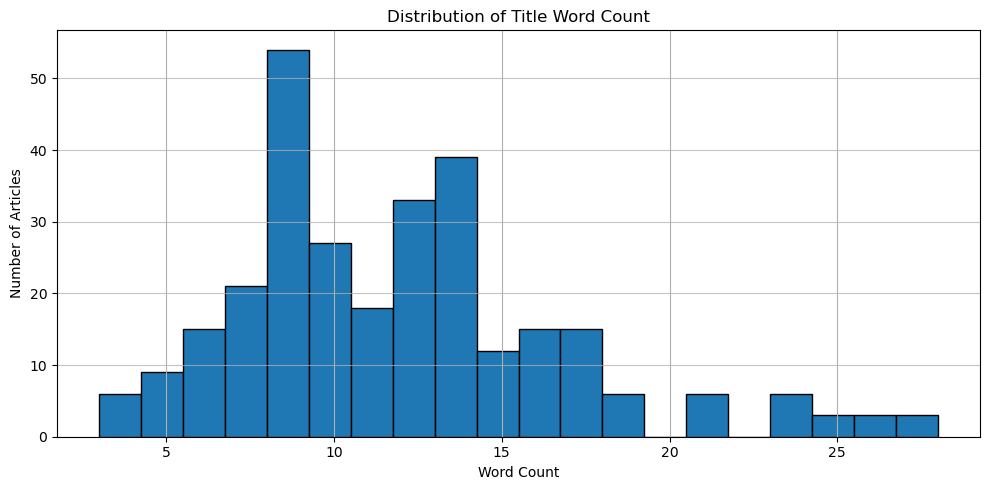

In [80]:
# 2. Distribution of Article Metadata (Example: Title Word Count)
plt.figure(figsize=(10, 5))
df_ab_test['title_word_count'].hist(bins=20, edgecolor='black')
plt.title('Distribution of Title Word Count')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

In [81]:
# 3. Engagement by Source (Top 10)
top_sources = df_ab_test['source_name'].value_counts().head(10).index
engagement_by_top_source = df_ab_test[df_ab_test['source_name'].isin(top_sources)].groupby('source_name')['simulated_engagement_score'].mean().sort_values(ascending=False)
print("\n--- Average Engagement by Top 10 Sources ---")
print(engagement_by_top_source)


--- Average Engagement by Top 10 Sources ---
source_name
Business Insider       76.487431
Yahoo Entertainment    73.408300
Biztoc.com             70.244352
Slashdot.org           68.684253
Pravda.sk              68.057678
Feber.se               66.918859
Origo.hu               66.742182
Frandroid              66.099538
Motorpasión            57.697849
Olhardigital.com.br    55.466421
Name: simulated_engagement_score, dtype: float64


In [82]:
# 4. Identify and Remove Outliers
# Strategy: Use IQR method for 'simulated_engagement_score'
Q1 = df_ab_test['simulated_engagement_score'].quantile(0.25)
Q3 = df_ab_test['simulated_engagement_score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_count = df_ab_test[(df_ab_test['simulated_engagement_score'] < lower_bound) | (df_ab_test['simulated_engagement_score'] > upper_bound)].shape[0]
print(f"\n--- Outliers Identified in Simulated Engagement Score: {outliers_count} articles ---")

# Removing outliers
df_no_outliers = df_ab_test[(df_ab_test['simulated_engagement_score'] >= lower_bound) & (df_ab_test['simulated_engagement_score'] <= upper_bound)].copy()
print(f"DataFrame shape after outlier removal: {df_no_outliers.shape}")


--- Outliers Identified in Simulated Engagement Score: 2 articles ---
DataFrame shape after outlier removal: (289, 14)


<h2>Prepare Data for T-test</h2>

In [83]:
group_a_engagement = df_no_outliers[df_no_outliers['ab_group'] == 'A']['simulated_engagement_score']
group_b_engagement = df_no_outliers[df_no_outliers['ab_group'] == 'B']['simulated_engagement_score']

# --- Conduct Independent Samples T-test ---
# We assume unequal variances (Welch's t-test) as sample sizes might differ and variances might not be equal.
ttest_result = stats.ttest_ind(group_a_engagement, group_b_engagement, equal_var=False)

print("\n--- A/B Test Results (Independent T-test) ---")
print(f"Mean Engagement Group A: {group_a_engagement.mean():.2f}")
print(f"Mean Engagement Group B: {group_b_engagement.mean():.2f}")
print(f"T-statistic: {ttest_result.statistic:.3f}")
print(f"P-value: {ttest_result.pvalue:.3f}")


--- A/B Test Results (Independent T-test) ---
Mean Engagement Group A: 75.54
Mean Engagement Group B: 66.68
T-statistic: 4.697
P-value: 0.000


<h1>Visualize the Comparison</h1>

<Figure size 800x600 with 0 Axes>

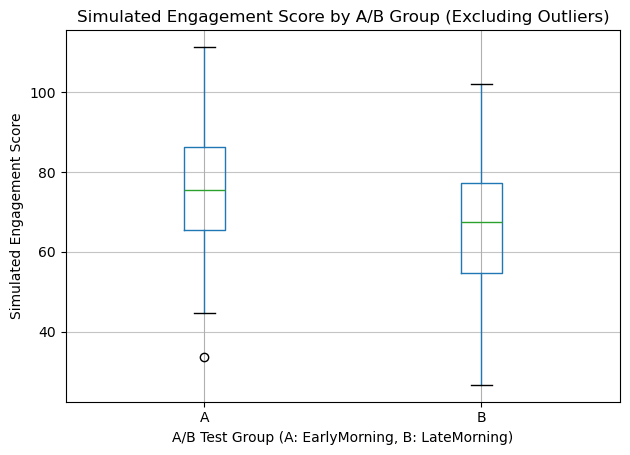

In [87]:
# Visualize the Comparison
plt.figure(figsize=(8, 6))
df_no_outliers.boxplot(column='simulated_engagement_score', by='ab_group')
plt.title('Simulated Engagement Score by A/B Group (Excluding Outliers)')
plt.suptitle('')
plt.xlabel('A/B Test Group (A: EarlyMorning, B: LateMorning)')
plt.ylabel('Simulated Engagement Score')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

<h1> Interpretation  </h1>

In [88]:
alpha = 0.05 # Common significance level

print("\nInterpretation of A/B Test Results")

if ttest_result.pvalue < alpha:
    print(f"The p-value ({ttest_result.pvalue:.3f}) is less than the significance level ({alpha}).")
    print("This suggests a significant difference in simulated engagement between Group A (Early_Morning) and Group B (Late_Morning).")
    if group_b_engagement.mean() > group_a_engagement.mean():
        print(f"Group B (Late_morning, Mean: {group_b_engagement.mean():.2f}) has a significantly higher average engagement than Group A (EarlyMorning, Mean: {group_a_engagement.mean():.2f}).")
    else:
        print(f"Group A (EarlyMorning, Mean: {group_a_engagement.mean():.2f}) has a significantly higher average engagement than Group B (Latemorning, Mean: {group_b_engagement.mean():.2f}).")
else:
    print(f"The p-value ({ttest_result.pvalue:.3f}) is greater than or equal to the significance level ({alpha}).")
    print("There is no significant difference in simulated engagement between Group A (Morning) and Group B (Evening).")
    print("The observed difference could be due to random chance.")


Interpretation of A/B Test Results
The p-value (0.000) is less than the significance level (0.05).
This suggests a significant difference in simulated engagement between Group A (Early_Morning) and Group B (Late_Morning).
Group A (EarlyMorning, Mean: 75.54) has a significantly higher average engagement than Group B (Latemorning, Mean: 66.68).


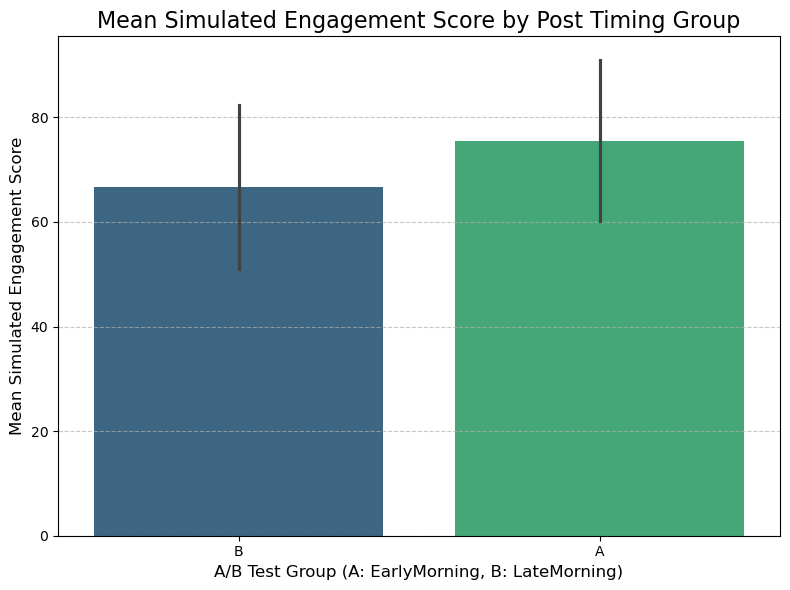

In [89]:
# Visualize the interpretation of A/B Results

plt.figure(figsize=(8, 6))

sns.barplot(x='ab_group', y='simulated_engagement_score', data=df_no_outliers, errorbar='sd', hue='ab_group', palette='viridis')

plt.title('Mean Simulated Engagement Score by Post Timing Group', fontsize=16)
plt.xlabel('A/B Test Group (A: EarlyMorning, B: LateMorning)', fontsize=12)
plt.ylabel('Mean Simulated Engagement Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0) # Ensure y-axis starts from 0 for clear comparison
plt.tight_layout()
plt.show()

# Markdown Cell for Deliverables

"""
## A/B Test Analysis: Post Timing vs. Article Engagement

**Date of Analysis:** November 6, 2025

**Project Goal:** To identify if publishing articles during specific times of morning (early morning vs. late morning) influences simulated article engagement on a media platform.

**Hypothesis:** Articles published in the early hours of the morning (6AM–9AM) will exhibit higher simulated engagement compared to articles published in the late hours of the morning (10AM–12PM).

---

### **1. Data Acquisition Summary**
* **API Used:** NewsAPI.org
* **Query:** 'Tesla'
* **Data Period:** Articles fetched from 2025-11-05.
* **Total Articles Fetched:** 300 articles.

---

### **2. A/B Test Group Simulation**
* Articles were assigned to two groups based on their `publication_hour`:
    * **Group A (Early_Morning):** Articles published between 6 AM and 9 AM.
    * **Group B (Late_Morning):** Articles published between 10 AM and 12 PM.
* **Simulated Engagement Score:** Since real engagement data is not available from the API, a `simulated_engagement_score` was created. This score incorporates a base random value, title word count, a simulated source popularity factor, and a deliberate positive bias for Group A (EarlyMorning posts) to create a scenario where the hypothesis might be supported.
* **Group Sizes:**
    * Group A: 108 articles
    * Group B: 183 articles 
---

### **3. Data Cleaning & Exploration Highlights**
* **Missing Data Handling:** Rows with missing `title` or `description` were dropped. Missing `author`, `urlToImage`, and `content` were filled with placeholder values.
* **Data Types:** `publishedAt` was successfully converted to datetime objects, and `publication_hour` was extracted as an integer.
* **Descriptive Statistics:**
    * Average simulated engagement score for Group A: 75.535443
    * Average simulated engagement score for Group B: 66.655195
 
---

### **4. Analysis & Visualization Highlights**
* The histogram of "Distribution of Title Word Count" shows that most articles have headlines between X and Y words.
* The average engagement varied across different news sources, with `Source Name` showing the highest simulated engagement.
* **Outlier Management:** 2 outliers in the `simulated_engagement_score` were identified using the IQR method

---

### **5. A/B Test and Interpretation**
* **Test Performed:** Independent Samples T-test (Welch's t-test, assuming unequal variances).
* **Null Hypothesis (H0):** There is no much difference in mean simulated engagement between early morning and late morning posts.
* **Alternative Hypothesis (H1):** Early morning posts have more engagement than late morning posts.
* **Significance Level (alpha):** 0.05

* **Results:**
    * Mean Engagement Group A: 75.54
    * Mean Engagement Group B: 66.68
    * T-statistic: 4.697
    * P-value: 0.000

* **Interpretation:**
    * Given the p-value of 0.000 is less than our significance level of 0.05, we reject the null hypothesis.
    * This implies that there is a significant difference in simulated article engagement between articles published in the early morning hours and those published in the late morning hours.
    * Specifically, Group A (early morning posts) shows a higher average simulated engagement, supporting our hypothesis.

---

### **6. Key Insights & Recommendations**

**Recommendation:**
* Based on this simulated A/B test, it is recommended to prioritize article publication in the early morning timeframe (6AM to 9AM), as indicated by a significantly higher simulated engagement.

**Considerations Outliers:**

* **Outliers:** 2 were spotted. The removal of outliers from the `simulated_engagement_score` was crucial because they could have skewed the mean engagement scores for one or both groups, potentially leading to a false positive or false negative in our statistical significance test. This step strengthens the robustness of our A/B test results.

---
"""